In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/Github/

/content/drive/MyDrive/Github


In [3]:
%cd Pandas4x4-ANN

/content/drive/MyDrive/Github/Pandas4x4-ANN


### Import Libraries


In [4]:
# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

In [5]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)
#import keras_cv.layers as kcvl

2.14.0


In [6]:
# Import some other useful libraries
import pandas as pd
import sklearn as skl
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from prettytable import PrettyTable

### Load of the preprocessed dataset


In [7]:
data = np.load('dataset (1).npz',allow_pickle=True)
lst = data.files
X = data[lst[0]]
y = data[lst[1]]

# Convert values in data to int
X = X.astype(int)

### Create train and validation sets

In [8]:
# Normalize data to the range [0, 1]
X_train_val = (X / 255).astype('float32')

# Create a mapping from label string to values
map = {'healthy':0 , 'unhealthy':1}

# Map labels from string to the corresponding encoding
int_labels = np.array([map[label.decode()] for label in y])

# Convert labels to categorical format using one-hot encoding
y_train_val = tfk.utils.to_categorical(int_labels)


# Split data into training and validation sets, maintaining class distribution (0.9/0.1)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, random_state=seed, test_size=0.1, stratify=y_train_val)

#del X_train_val, y_train_val

### Inference

In [10]:
# Load the saved model
model = tfk.models.load_model('convnext_FTall')

In [11]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 img_augmentation (Sequenti  (None, 96, 96, 3)         0         
 al)                                                             
                                                                 
 tf.math.multiply_1 (TFOpLa  (None, 96, 96, 3)         0         
 mbda)                                                           
                                                                 
 tf.cast_1 (TFOpLambda)      (None, 96, 96, 3)         0         
                                                                 
 convnext_large (Functional  (None, 3, 3, 1536)        196230336 
 )                                                               
                                                             

In [12]:
# Get rid of augmentation layers (RandAugment is active also at test time)
inference_model = tfk.Model(inputs= model.layers[2].input, outputs= model.output)

In [13]:
inference_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 tf.math.multiply_1 (TFOpLa  (None, 96, 96, 3)         0         
 mbda)                                                           
                                                                 
 tf.cast_1 (TFOpLambda)      (None, 96, 96, 3)         0         
                                                                 
 convnext_large (Functional  (None, 3, 3, 1536)        196230336 
 )                                                               
                                                                 
 avg_pool (GlobalAveragePoo  (None, 1536)              0         
 ling2D)                                                         
                                                             

Input image


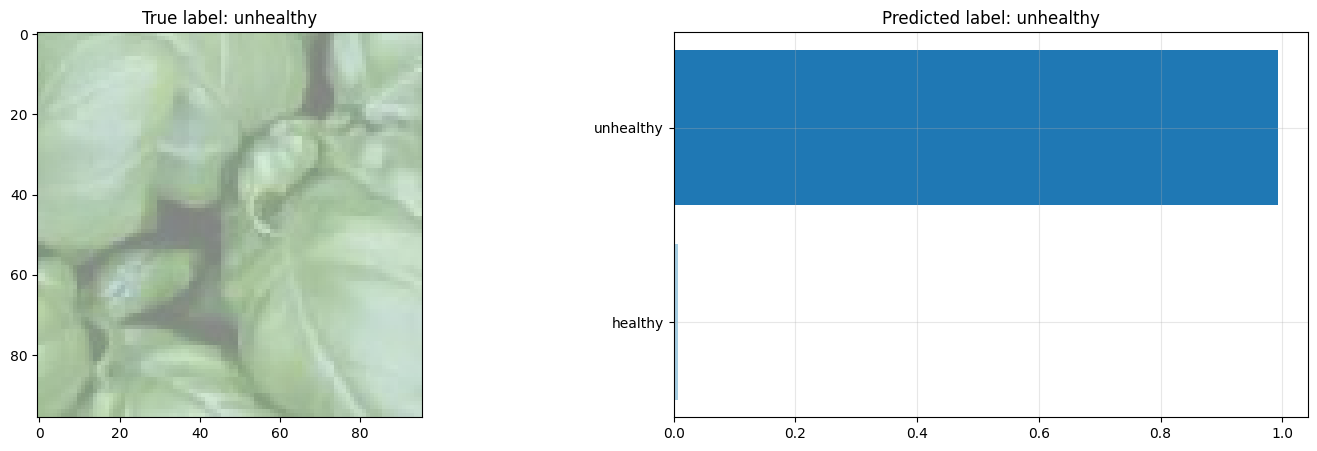

In [19]:
import random

# Choose a random unhealthy image for visualization
unhealthy_val_images = X_val[y_val[:,1] == 1]
image = random.randint(0, len(unhealthy_val_images))

# Display the input image, true label, and predicted label
print('Input image')
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 5)
ax1.imshow((unhealthy_val_images[image] + 1) / 2)
ax1.set_title('True label: ' + 'unhealthy')
prediction = inference_model.predict(np.expand_dims(unhealthy_val_images[image], axis=0), verbose=0)
prediction.shape
if np.argmax(prediction) == 1:
  pred_label = 'unhealthy'
else:
  pred_label = 'healthy'
ax2.barh(list(['healthy', 'unhealthy']), np.squeeze(prediction, axis=0), color=plt.get_cmap('Paired').colors)
ax2.set_title('Predicted label: ' + pred_label)
ax2.grid(alpha=0.3)
plt.show()

In [20]:
# Predict labels for the entire test set
predictions = inference_model.predict(X_val, verbose=0)

# Display the shape of the predictions
print("Predictions Shape:", predictions.shape)

Predictions Shape: (612, 2)


Accuracy: 0.9673
Precision: 0.9674
Recall: 0.9673
F1: 0.9673


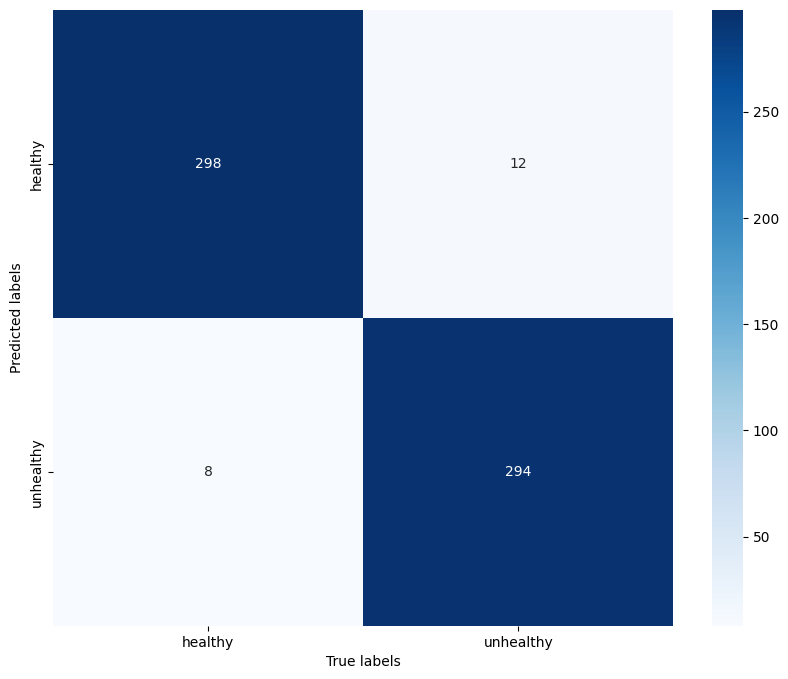

In [21]:
# Compute the confusion matrix
confusion_matrix = skl.metrics.confusion_matrix(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1))

# Compute classification metrics
accuracy = accuracy_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1), average='macro')

# Display the computed metrics
print('Accuracy:', accuracy.round(4))
print('Precision:', precision.round(4))
print('Recall:', recall.round(4))
print('F1:', f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix.T, xticklabels=list(['healthy', 'unhealthy']), yticklabels=list(['healthy', 'unhealthy']), cmap='Blues', annot= True, fmt='d')
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

### Plot the ROC curve and find the best threshold

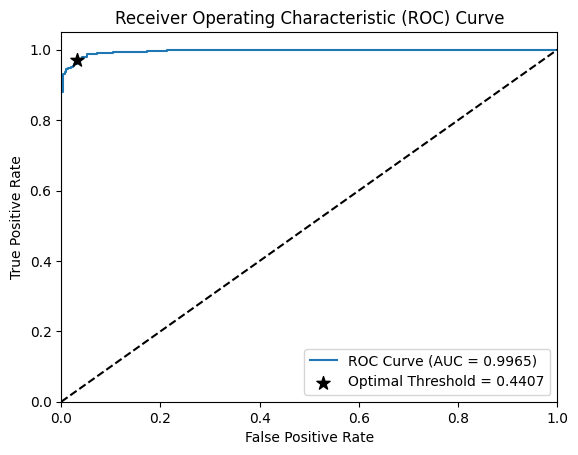

Optimal Threshold: 0.44066569209098816


In [23]:
from sklearn.metrics import roc_curve, auc

# Predicted probabilities for class 1 (unhealthy)
predicted_probabilities = predictions[:,1]
# True probabilities for class 1 (unhealthy)
true_probabilities = y_val[:,1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(true_probabilities, predicted_probabilities)
roc_auc = auc(fpr, tpr)

# Calculate Sensitivity (True Positive Rate) and Specificity (1 - False Positive Rate)
sensitivity = tpr
specificity = 1 - fpr

# Calculate Youden's J statistic (tpr - fpr) for each threshold value
youden = sensitivity + specificity - 1

# Find the optimal threshold maximising the difference between tpr and fpr
optimal_threshold = thresholds[np.argmax(youden)]

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal reference line

# Annotate the optimal threshold with a star marker
plt.scatter(fpr[np.argmax(youden)], tpr[np.argmax(youden)], marker='*',  color='black', s=100, label=f'Optimal Threshold = {optimal_threshold:.4f}', zorder=5)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

print(f'Optimal Threshold: {optimal_threshold}')

In [24]:
def predict_given_threshold(prediction_probabilities, threshold= 0.5):
  """
    Predict the class based on a threshold.
    For each element in the 'probabilities' array, the function assigns class 1 ('unhealthy') if the
    probability is greater than or equal to the threshold; otherwise, it assigns class 0 ('healthy').
    The result is an array of predicted classes reflecting the classification decisions for each
    corresponding probability in the input array.

    Parameters:
    - probabilities (array-like): Array or tensor of predicted probabilities of class 1.
    - threshold (float): The threshold value for classification.

    Returns:
    - array: Array of predicted classes (1 or 0).
  """
  return 1 * (prediction_probabilities[:,1] >= threshold)

Accuracy: 0.969
Precision: 0.969
Recall: 0.969
F1: 0.969


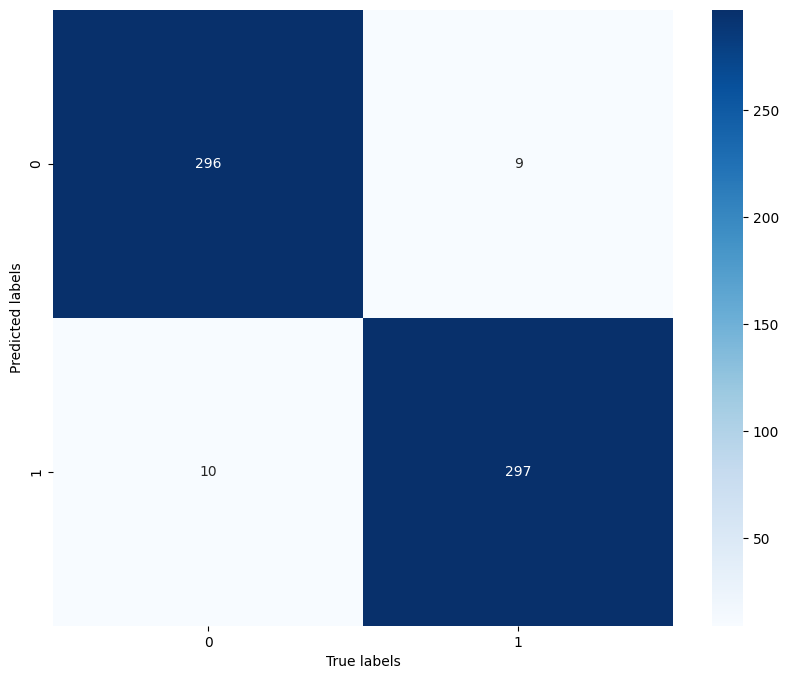

In [25]:
# Compute the new confusion matrix
confusion_matrix_new =  skl.metrics.confusion_matrix(np.argmax(y_val, axis=-1), predict_given_threshold(predictions, optimal_threshold))

# Compute classification metrics
accuracy = accuracy_score(np.argmax(y_val, axis=-1), predict_given_threshold(predictions, optimal_threshold))
precision = precision_score(np.argmax(y_val, axis=-1), predict_given_threshold(predictions, optimal_threshold), average='macro')
recall = recall_score(np.argmax(y_val, axis=-1), predict_given_threshold(predictions, optimal_threshold), average='macro')
f1 = f1_score(np.argmax(y_val, axis=-1), predict_given_threshold(predictions, optimal_threshold), average='macro')

# Display the computed metrics
print('Accuracy:', accuracy.round(4))
print('Precision:', precision.round(4))
print('Recall:', recall.round(4))
print('F1:', f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix_new.T, cmap='Blues', annot= True, fmt='d')
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()